Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Memuat gambar dari Google Drive...
Gambar berhasil dimuat!
Mulai proses transfer gaya dengan parameter baru untuk optimasi lebih lanjut...
........................................................................................................................................................................................................
Epoch 1/30 selesai.
........................................................................................................................................................................................................
Epoch 2/30 selesai.
........................................................................................................................................................................................................
Epoch 3/30 selesai.
.....................................................................

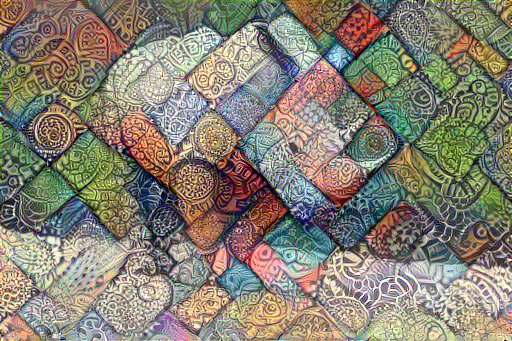

In [4]:
import tensorflow as tf
import numpy as np
import PIL.Image
import time
import functools
import os

# --- 0. Koneksi ke Google Drive (PENTING) ---
from google.colab import drive
# Ini akan meminta izin akses ke Google Drive Anda
drive.mount('/content/drive')

# --- 1. Konfigurasi Path Gambar (Sesuai Path Anda) ---
# Saya menggunakan path persis seperti yang Anda kirimkan
style_path = '/content/drive/MyDrive/Dataset/Dataset_DeepLearning/Style_Objek.jpg'
content_path = '/content/drive/MyDrive/Dataset/Dataset_DeepLearning/Objek2.jpg'
# Pengecekan apakah file benar-benar ada sebelum lanjut
if not os.path.exists(content_path):
    print(f"ERROR: File tidak ditemukan di: {content_path}")
    print("Cek kembali apakah ada spasi di nama folder 'Dataset /' di Google Drive Anda.")
if not os.path.exists(style_path):
    print(f"ERROR: File tidak ditemukan di: {style_path}")

# --- 2. Fungsi Helper untuk Mengolah Gambar ---
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)
  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# --- 3. Memuat Model VGG19 ---
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
    return {'content': content_dict, 'style': style_dict}

# --- 4. Perhitungan Loss ---
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

# --- 5. Eksekusi Training ---
print("Memuat gambar dari Google Drive...")
try:
    content_image = load_img(content_path)
    style_image = load_img(style_path)
    print("Gambar berhasil dimuat!")
except Exception as e:
    print(f"\nGAGAL MEMUAT GAMBAR. Error: {e}")
    print("Pastikan path sudah benar dan Google Drive sudah termount.")
    # Stop eksekusi jika gambar gagal dimuat
    raise e

extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

# Updated parameters for further optimization
opt = tf.optimizers.Adam(learning_rate=0.005, beta_1=0.99, epsilon=1e-1)

style_weight = 1e2 # 100.0
content_weight = 1e2 # 100.0

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += tf.image.total_variation(image) * 70  # Updated multiplier
  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image, 0.0, 1.0))

# --- Training Loop with further modified epochs and steps_per_epoch ---
epochs = 30  # Updated
steps_per_epoch = 200 # Updated

print("Mulai proses transfer gaya dengan parameter baru untuk optimasi lebih lanjut...")
start = time.time()

for n in range(epochs):
  for m in range(steps_per_epoch):
    train_step(image)
    print('.', end='', flush=True)
  print(f"\nEpoch {n+1}/{epochs} selesai.")

end = time.time()
print(f"\nSelesai dalam {end-start:.1f} detik")

# --- 6. Simpan Hasil ---
# Simpan hasil di folder yang sama dengan dataset agar mudah ditemukan
output_path = '/content/drive/MyDrive/Dataset/Dataset_DeepLearning/Hasil_NST_Results_Optimized_V2.jpg' # Changed output filename
result_image = tensor_to_image(image)
result_image.save(output_path)
print(f"Gambar berhasil disimpan di Google Drive Anda: {output_path}")

# Tampilkan preview kecil
try:
  display(result_image)
except:
  pass